# Transfer Learning - Brain Tumor Classification for MRI Images - with ResNet50V2

## Load Train And Test Data

In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

# Target Labels
labels =['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

train_predictors = list()
train_target = list()

test_predictors = list()
test_target = list()

image_widh_hight = 160

print('Loading training dataset .... ')
for label in labels:
    # Load training images with label as target.
    training_img_path = os.path.join(r"data/Training/", label)
    print('Label:',label)
    for file_name in tqdm(os.listdir(training_img_path)):
        img = cv2.imread(os.path.join(training_img_path, file_name))
        img = cv2.resize(img, (image_widh_hight, image_widh_hight))
        train_predictors.append(img)
        train_target.append(label)

# Create a dataframe.
train_df = pd.DataFrame({'Image':train_predictors, 'Label':train_target})

print('\n\nLoadinig testing dataset ...')
for label in labels:
    # Load testing images with label as target.
    testing_img_path = os.path.join(r"data/Testing/", label)
    print('Label:',label)
    for file_name in tqdm(os.listdir(testing_img_path)):
        img = cv2.imread(os.path.join(testing_img_path, file_name))
        img = cv2.resize(img, (image_widh_hight, image_widh_hight))
        test_predictors.append(img)
        test_target.append(label)

# Create a dataframe
test_df = pd.DataFrame({'Image': test_predictors, 'Label':test_target})


Loading training dataset .... 
Label: glioma_tumor


100%|███████████████████████████████████████████████████████████████████████████████| 826/826 [00:05<00:00, 160.31it/s]


Label: meningioma_tumor


100%|███████████████████████████████████████████████████████████████████████████████| 822/822 [00:05<00:00, 145.85it/s]


Label: no_tumor


100%|███████████████████████████████████████████████████████████████████████████████| 395/395 [00:02<00:00, 176.81it/s]


Label: pituitary_tumor


100%|███████████████████████████████████████████████████████████████████████████████| 827/827 [00:06<00:00, 135.58it/s]




Loadinig testing dataset ...
Label: glioma_tumor


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 122.59it/s]


Label: meningioma_tumor


100%|███████████████████████████████████████████████████████████████████████████████| 115/115 [00:00<00:00, 119.00it/s]


Label: no_tumor


100%|███████████████████████████████████████████████████████████████████████████████| 105/105 [00:00<00:00, 148.12it/s]


Label: pituitary_tumor


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [00:00<00:00, 77.24it/s]


## Check Target Label Distribution

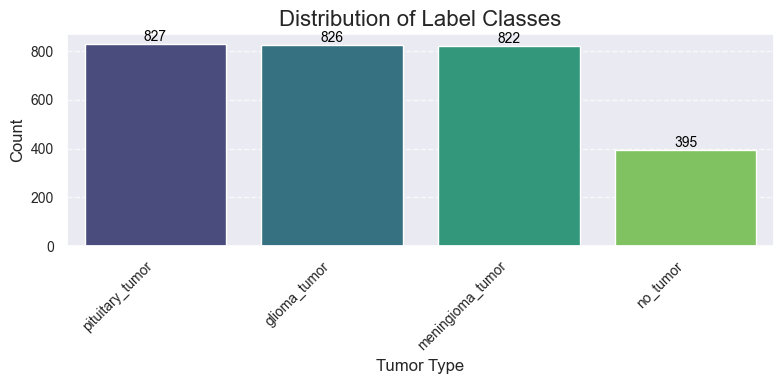

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming train_df contains your DataFrame

# Count the occurrences of each label
label_counts = train_df['Label'].value_counts()

# Set a Seaborn style
sns.set(style="darkgrid")

# Create a bar plot using Seaborn
plt.figure(figsize=(8, 4))
ax = sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")

# Add count numbers at the top of each bar
for i, count in enumerate(label_counts.values):
    ax.text(i, count + 0.1, str(count), ha='center', va='bottom', fontsize=10, color='black')

# Customize plot aesthetics
plt.title('Distribution of Label Classes', fontsize=16)
plt.xlabel('Tumor Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display plot
plt.tight_layout()
plt.show()


## See Sample Images From Each Class

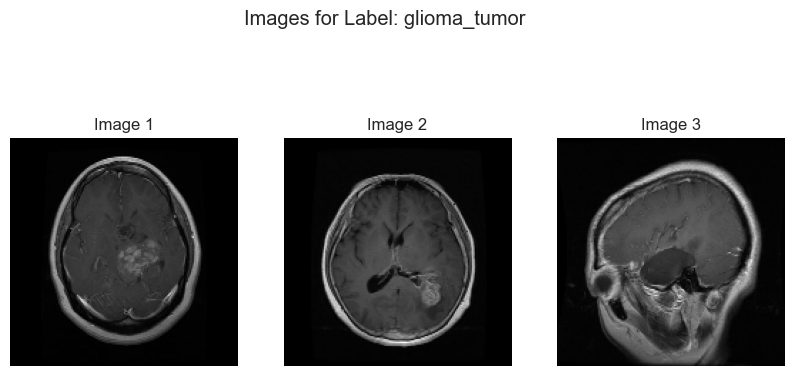

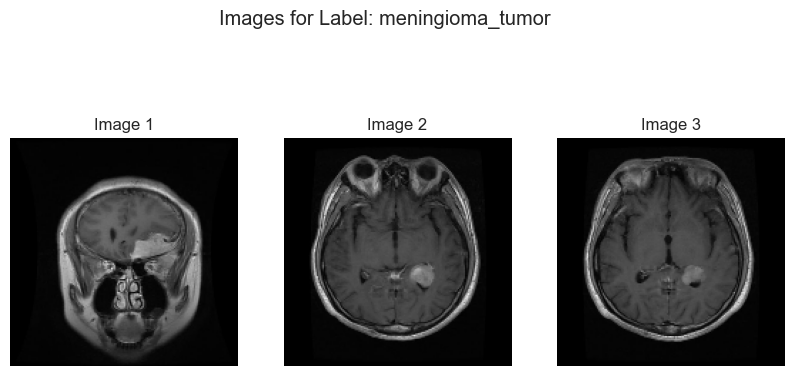

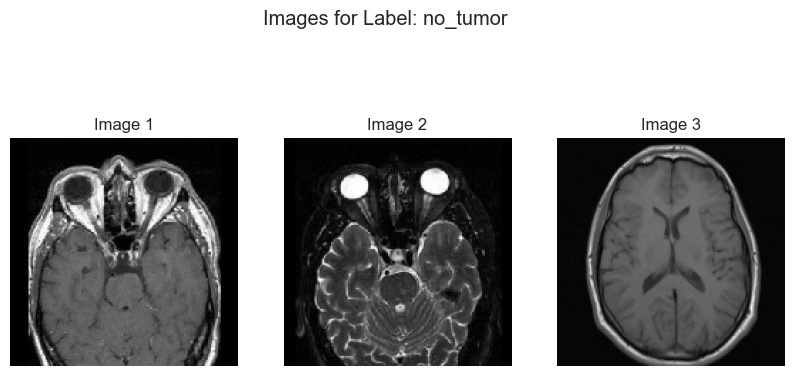

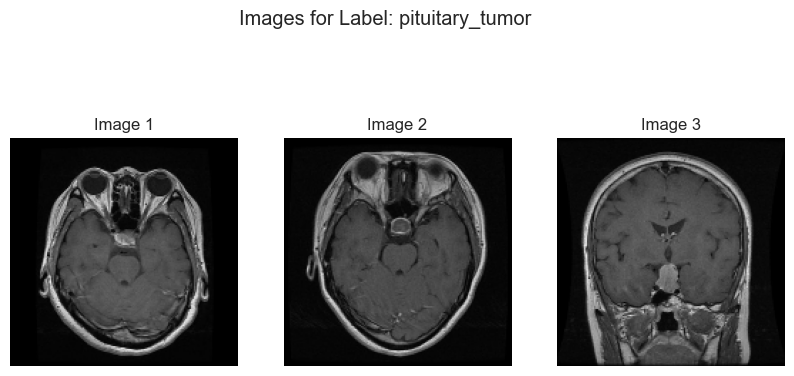

In [3]:
import matplotlib.pyplot as plt

def display_images_for_label(label_name, num_images=3):
    print('==============================================================================================================')
    # Filter the DataFrame to select rows with the given label
    label_df = train_df[train_df['Label'] == label_name]

    # Take the first `num_images` images for this label
    images = label_df['Image'].values[:num_images]

    # Create a grid of subplots to display the images
    fig, axes = plt.subplots(1, num_images, figsize=(10, 5))

    for i, img in enumerate(images):
        # Display the image on the subplot
        axes[i].imshow(img)
        axes[i].set_title(f"Image {i + 1}")
        axes[i].axis('off')

    # Set the title for the entire row of images
    plt.suptitle(f"Images for Label: {label_name}")
    plt.show()

# Display images for each label
for label in labels:
    display_images_for_label(label)


## Prepare Data For the Training 

In [4]:
# Convert list to n-darray
train_predictors = np.array(train_predictors)
test_predictors = np.array(test_predictors)

print("Training Data Shape:", train_predictors.shape)
print("Testing Data Shape:", test_predictors.shape)

Training Data Shape: (2870, 160, 160, 3)
Testing Data Shape: (394, 160, 160, 3)


## One-hot Encode Target Variable 

In [5]:
import tensorflow as tf

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_target_encoded = label_encoder.fit_transform(train_target)
test_target_encoded = label_encoder.transform(test_target)

train_target_ohe = tf.keras.utils.to_categorical(train_target_encoded)
test_target_ohe = tf.keras.utils.to_categorical(test_target_encoded)


train_target_ohe

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32)

## Transfer Learning with ResNet50V2

In [6]:
from tensorflow.keras.applications import ResNet50V2

resnet = ResNet50V2(weights='imagenet', include_top=False, input_shape=(image_widh_hight, image_widh_hight, 3))

## Create a Model

In [17]:
model = resnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=resnet.input, outputs = model)

# Show model parameters.
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 166, 166, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 80, 80, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 82, 82, 64)           0         ['conv1_conv[0][0]']          
                                                                                              

## Compile the Model

In [18]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Callacks 

In [19]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint

tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("brain_tummor_model.h5", monitor="val_accuracy", save_best_only=True, mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

## Train the Model 

In [11]:
history = model.fit(train_predictors, train_target_ohe, validation_split=0.1, epochs =12, verbose=1, batch_size=32, callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/12
81/81 [==============================] - ETA: 0s - loss: 0.6003 - accuracy: 0.7816
Epoch 1: val_accuracy improved from -inf to 0.06620, saving model to resnet50.h5


C:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


81/81 [==============================] - 796s 9s/step - loss: 0.6003 - accuracy: 0.7816 - val_loss: 55.8584 - val_accuracy: 0.0662 - lr: 0.0010
Epoch 2/12
81/81 [==============================] - ETA: 0s - loss: 0.3020 - accuracy: 0.9059
Epoch 2: val_accuracy improved from 0.06620 to 0.93031, saving model to resnet50.h5
81/81 [==============================] - 770s 10s/step - loss: 0.3020 - accuracy: 0.9059 - val_loss: 0.1737 - val_accuracy: 0.9303 - lr: 0.0010
Epoch 3/12
81/81 [==============================] - ETA: 0s - loss: 0.2488 - accuracy: 0.9137
Epoch 3: val_accuracy did not improve from 0.93031
81/81 [==============================] - 776s 10s/step - loss: 0.2488 - accuracy: 0.9137 - val_loss: 7.6729 - val_accuracy: 0.0662 - lr: 0.0010
Epoch 4/12
81/81 [==============================] - ETA: 0s - loss: 0.1967 - accuracy: 0.9365 
Epoch 4: val_accuracy did not improve from 0.93031

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
81/81 [===============

## See The Learning Curve 

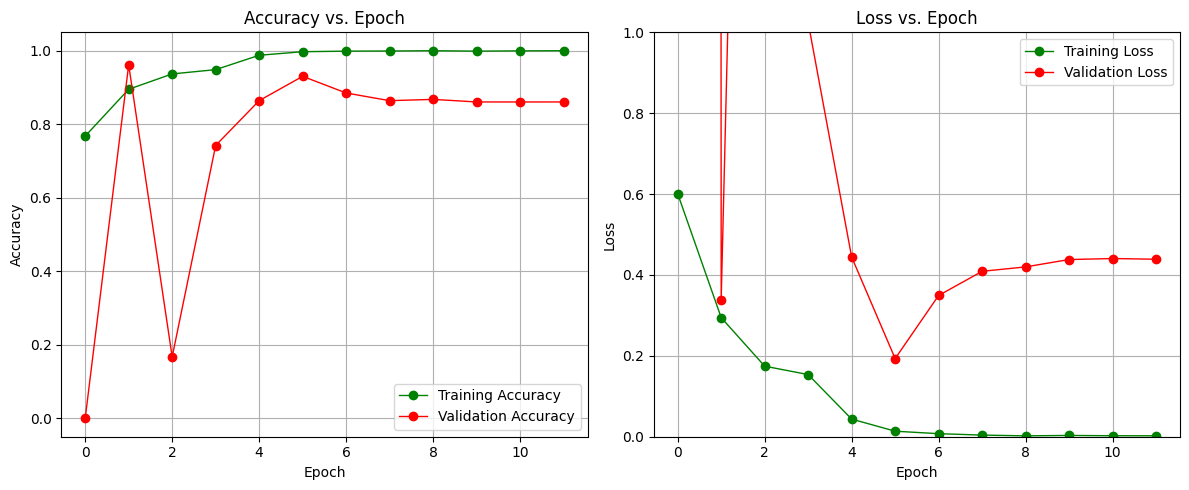

In [30]:
import matplotlib.pyplot as plt

# Create a single graph with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot accuracy vs. epoch
ax1.plot(history.history['accuracy'], label='Training Accuracy', marker='o', color = 'green', linestyle='-',linewidth=1)
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o', color = 'red',  linestyle='-',linewidth=1)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy vs. Epoch')
ax1.legend()

# Plot loss vs. epoch
ax2.plot(history.history['loss'], label='Training Loss', marker='o', color = 'green', linestyle='-',linewidth=1)
ax2.plot(history.history['val_loss'], label='Validation Loss', marker='o', color = 'red',  linestyle='-',linewidth=1)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_title('Loss vs. Epoch')
ax2.set_ylim(0, 1)  # Set the y-axis limits
ax2.legend()

# Add grid lines
ax1.grid(True)
ax2.grid(True)

# Add a legend with a transparent background
leg = ax1.legend(framealpha=0.8)
leg = ax2.legend(framealpha=0.8)

# Adjust the spacing between subplots
plt.tight_layout()

# Save the figure or display it
plt.savefig('training_plot.png')
plt.show()


## Prediction on Test Dataset 

In [114]:
test_pred = model.predict(test_predictors)
test_pred = np.argmax(test_pred, axis=1)
test_target_class = np.argmax(test_target_ohe, axis=1)

13/13 [==============================] - 18s 1s/step


## Label and Curresponding Number 

In [115]:
for index, class_name in enumerate(label_encoder.classes_):
    print(f"{index} : {class_name}")

0 : glioma_tumor
1 : meningioma_tumor
2 : no_tumor
3 : pituitary_tumor


## Evaluate Model Performance

In [116]:
from sklearn.metrics import classification_report

print(classification_report(test_target_class, test_pred))

              precision    recall  f1-score   support

           0       1.00      0.22      0.36       100
           1       0.73      1.00      0.84       115
           2       0.66      1.00      0.80       105
           3       0.95      0.72      0.82        74

    accuracy                           0.75       394
   macro avg       0.83      0.73      0.70       394
weighted avg       0.82      0.75      0.70       394



## Classification Report Heatmap 

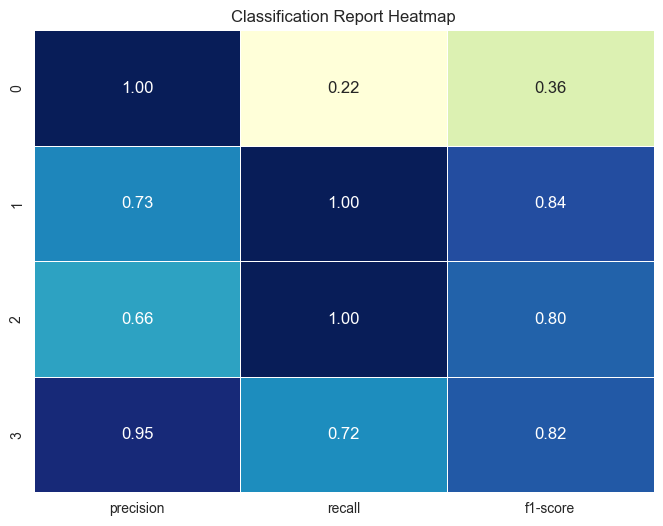

In [117]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(test_target_class, test_pred, output_dict=True)

# Convert the classification report to a DataFrame
report_df = pd.DataFrame(report).transpose()

# Create a heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(report_df.iloc[:-3, :-1], annot=True, cmap='YlGnBu', cbar=False, fmt=".2f", linewidths=.5)
plt.title('Classification Report Heatmap')
plt.show()


## UI Interface with Gradio

In [25]:
import gradio as gr
import io
from PIL import Image
import base64

# Librar to load model.
from tensorflow.keras.models import load_model

def load_model_weights(weight_file):
    return load_model(weight_file)

def reshape_image(img):
    img = cv2.resize(img, (image_widh_hight, image_widh_hight))
    return img

def make_prediction(input_image):

    # Read image in cv2 format.
    cv2_image = cv2.cvtColor(input_image, cv2.COLOR_RGB2BGR)

    # Resize the image.
    input_image =  cv2.resize(input_image, (image_widh_hight, image_widh_hight))

    # Add batch in the image
    expanded_image = np.expand_dims(input_image, axis=0)

    model_weights = r"brain_tummor_model.h5"
    model = load_model(model_weights)

    predicted_class_index = np.argmax(model.predict(expanded_image))
    predicted_class_name = label_encoder.classes_[predicted_class_index]

    return predicted_class_name

gr.close_all()
demo = gr.Interface(fn=make_prediction,
                    inputs=[gr.Image(label='Input Image')],
                    outputs = [gr.Textbox(label='Predicted Class')],
                    title = 'Brain Tumor Classifier',
                    allow_flagging = "never",
                    # examples = examples,
                    show_label=True,
                    examples = ['data/Testing/glioma_tumor/image.jpg', 'data/Testing/pituitary_tumor/image(10).jpg',
                              'data/Testing/no_tumor/image(103).jpg', 'data/Testing/meningioma_tumor/image(11).jpg']
                   )

demo.launch(share=True, server_port=23434)

Closing server running on port: 23434
Closing server running on port: 23434
Closing server running on port: 23434
Closing server running on port: 23434
Closing server running on port: 23434
Closing server running on port: 23434
Running on local URL:  http://127.0.0.1:23434
1/1 [==============================] - 2s 2s/step

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app.


1/1 [==============================] - 1s 1s/step


In [19]:
gr.close_all()

Closing server running on port: 23434
Closing server running on port: 23434
Closing server running on port: 23434
Closing server running on port: 23434
Closing server running on port: 23434
